In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
NUM_TRAIN = 49000

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_train = torchvision.datasets.CIFAR10("../datasets", train=True, 
                transform=transform)

cifar10_test = torchvision.datasets.CIFAR10("../datasets", train=False,
                transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=64,
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(cifar10_train, batch_size=64, 
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

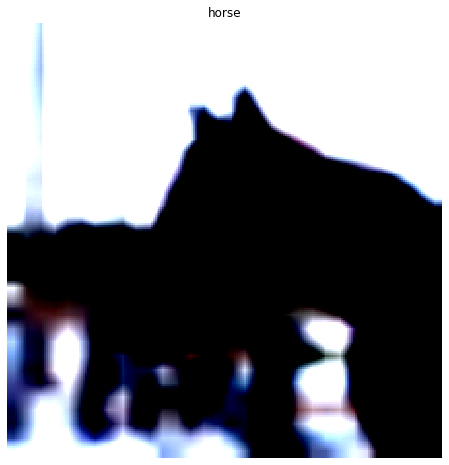

In [4]:
i = 5001
image, target = cifar10_train[i]
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[target])
plt.axis('off')

In [5]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.ReLU()
        )

        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)

        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.ReLU()
        )

        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)

        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)

        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)

        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)

        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self.pool2 = nn.Sequential(
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.ReLU()
        )

        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)

        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.classification = nn.Sequential(
            nn.AvgPool2d(7, stride=1),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool1(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool2(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.classification(x)

        return x


class Inception(nn.Module):
    def __init__(self, in_channel, channel_1, channel_3_r, channel_3, 
                 channel_5_r, channel_5, channel_pool_r):
        super(Inception, self).__init__()

        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(in_channel, channel_1, 1),
            nn.ReLU()
        )

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(in_channel, channel_3_r, 1),
            nn.ReLU(),
            nn.Conv2d(channel_3_r, channel_3, 3, padding=1),
            nn.ReLU()
        )

        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(in_channel, channel_5_r, 1),
            nn.ReLU(),
            nn.Conv2d(channel_5_r, channel_5, 5, padding=2),
            nn.ReLU()
        )

        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channel, channel_pool_r, 1),
            nn.ReLU()
        )

    def forward(self, x):
        out_1 = self.conv_1x1(x)
        out_2 = self.conv_3x3(x)
        out_3 = self.conv_5x5(x)
        out_4 = self.conv_pool(x)
        out = torch.cat((out_1, out_2, out_3, out_4), dim=1)

        return out


In [7]:
device = torch.device('cuda')
print("Using:", device)

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        return acc

def train_model(model, optimizer, loader=loader_train, epochs=10):
    model = model.to(device=device)
    loss_fc = nn.CrossEntropyLoss()
    loss_history = []
    acc_history = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader):
            model.train()
            x = x.to(device=device)
            y = y.to(device=device)

            optimizer.zero_grad()

            scores = model(x)
            loss = loss_fc(scores, y)

            loss.backward()

            optimizer.step()
        acc = check_accuracy(loader_val, model)
        print('Epoch {}, loss = {:.4f}, accuracy = {:.2f}%'.format(e, loss.item(), acc * 100))

        loss_history.append(loss)
        acc_history.append(acc)
    
    return loss_history, acc_history

Using: cuda


In [8]:
learning_rate = 1e-4
model = GoogLeNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history, acc_history = train_model(model, optimizer)

Epoch 0, loss = 1.5461, accuracy = 39.00%
Epoch 1, loss = 1.5114, accuracy = 43.30%
Epoch 2, loss = 1.4301, accuracy = 48.40%
Epoch 3, loss = 1.3808, accuracy = 52.50%
Epoch 4, loss = 1.4596, accuracy = 59.20%
Epoch 5, loss = 0.9506, accuracy = 62.00%
Epoch 6, loss = 0.8899, accuracy = 62.50%
Epoch 7, loss = 0.6022, accuracy = 68.50%
Epoch 8, loss = 0.8565, accuracy = 70.00%
Epoch 9, loss = 0.8610, accuracy = 71.10%


Text(0.5, 1.0, 'Training Accuracy history')

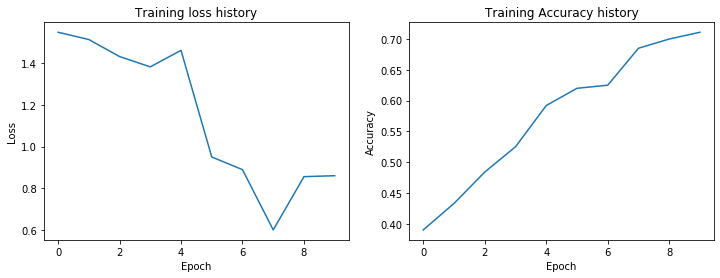

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss history')

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy history')

In [10]:
check_accuracy(loader_test, model)

0.7141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

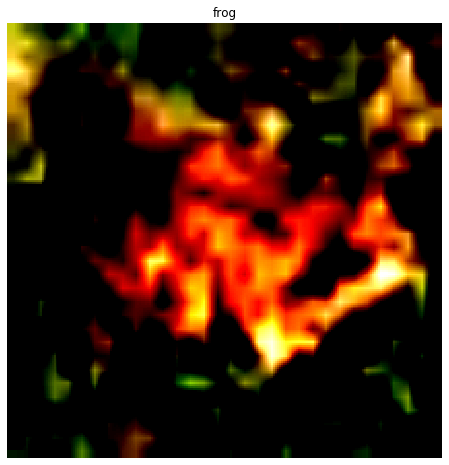

In [11]:
image, target = cifar10_test[i]
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[target])
plt.axis('off')

In [12]:
image = image.to(device=device)
predict = model(image.view(-1, 3, 224, 224))
classes[predict.argmax()]

'frog'